In [10]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

19.634954084936208


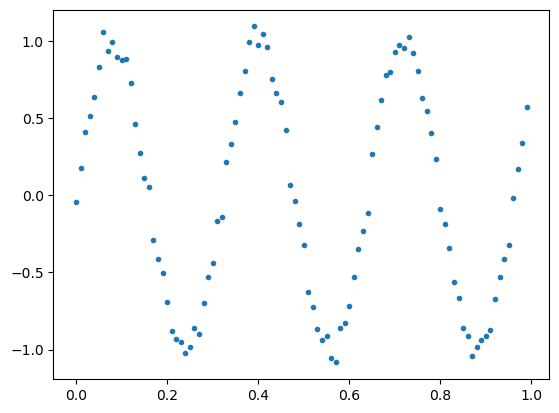

In [11]:
# generate simulated data
Npts = 100
dt = 0.01
ts = torch.arange(Npts) * dt
omega0 = 2 * np.pi / 0.32
zn = torch.sin(omega0 * ts)
zn += 0.1 * torch.randn(Npts)
plt.plot(ts, zn, '.')
print(omega0)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
zn = zn.to(device)
xn = torch.ones((2, Npts), device=device, requires_grad=True)
omega_t = torch.ones([1], device=device, requires_grad=True)


cuda


In [19]:
# simple harmonic oscillator model dx / df = f(x, omega)
def f(x, omega):
    f1 = x[1, :]
    f2 = - omega**2 * x[0, :]
    f = torch.stack([f1, f2], dim=0)
    return f

In [25]:
optim = torch.optim.Adam(params=[xn, omega_t], lr=0.1)
param_history = []
model_weight = 100  # try starting with this small and gradually increase durning optimization to try to avoid local mins
for niter in range(50000):
    optim.zero_grad()
    # f is evaluated twice as much as it needs to be, could be optimized
    # average of forward and backward euler
    error_model_n = xn[:, 1:] - xn[:, :-1] - 0.5 * dt * (f(xn[:, :-1], omega_t[0])  + f(xn[:, 1:], omega_t[0])) 
    loss_model = torch.mean( error_model_n ** 2) 
    loss_obs = torch.mean( (xn[0, :] - zn) ** 2)
    loss_total = model_weight * loss_model + loss_obs
    if niter % 1000 == 0:
        print(niter, loss_total.item(), loss_model.item(), loss_obs.item(), omega_t.item())
        param_history.append(omega_t.item())
    loss_total.backward()
    optim.step()

0 0.19471566379070282 0.0006773495697416365 0.1269807070493698 12.4231538772583
1000 0.13493221998214722 0.0005009557935409248 0.08483663201332092 14.84971809387207
2000 0.0876593291759491 0.0003239236248191446 0.055266961455345154 16.383201599121094
3000 0.05683251470327377 0.00020267246873117983 0.03656526654958725 17.265186309814453
4000 0.04037242755293846 0.000160412018885836 0.02433122508227825 17.870832443237305
5000 0.033947888761758804 0.00016936741303652525 0.017011146992444992 18.30623435974121
6000 0.01712585613131523 5.535675154533237e-05 0.011590180918574333 18.602041244506836
7000 0.015654031187295914 6.95700291544199e-05 0.008697028271853924 18.841096878051758
8000 0.010464007966220379 4.085679756826721e-05 0.006378328427672386 19.010822296142578
9000 0.007683881558477879 2.567300725786481e-05 0.00511658051982522 19.112058639526367
10000 0.00583388889208436 1.4944350368750747e-05 0.004339453764259815 19.234590530395508
11000 0.004898155108094215 1.09813745439169e-05 0.0

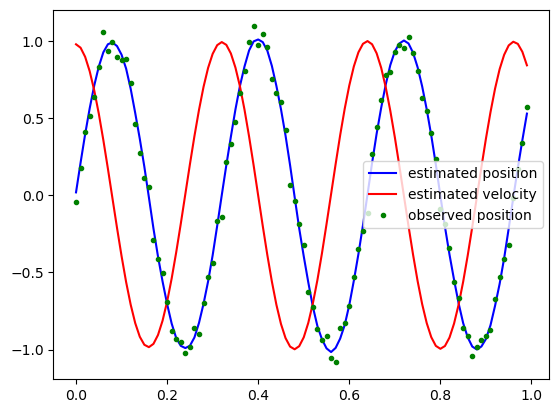

In [26]:
plt.plot(ts, xn[0, :].detach().cpu().numpy(), 'b-', label='estimated position')
plt.plot(ts, xn[1, :].detach().cpu().numpy() /omega0, 'r-', label='estimated velocity')
plt.plot(ts, zn.detach().cpu().numpy(), 'g.', label='observed position')
plt.legend()

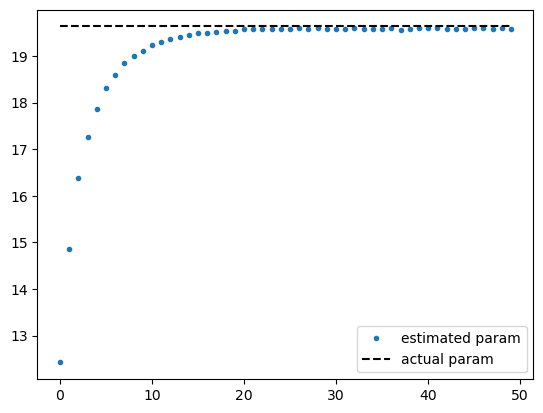

In [27]:
plt.plot(param_history, '.', label='estimated param')
plt.plot([0, len(param_history)-1], [omega0, omega0], 'k--', label='actual param')
plt.legend()
